In [ ]:
# Install required libraries if not already present
!pip install wordcloud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import pickle


In [ ]:
# Load dataset
df = pd.read_csv("WELFake_Dataset.csv")

# Data cleaning
df['title'].replace('', np.nan, inplace=True)
df['text'].replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.drop(["Unnamed: 0"], axis=1, inplace=True)

# Create combined text column
df["title_text"] = df["title"] + df["text"]
df["body_len"] = df["title_text"].apply(lambda x: len(x) - x.count(" "))

# Target variable
y = df.label

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['title_text'], y, test_size=0.33, random_state=53)


<ipython-input-4-e6bfbd259fa7>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['title'].replace('', np.nan, inplace=True)
<ipython-input-4-e6bfbd259fa7>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

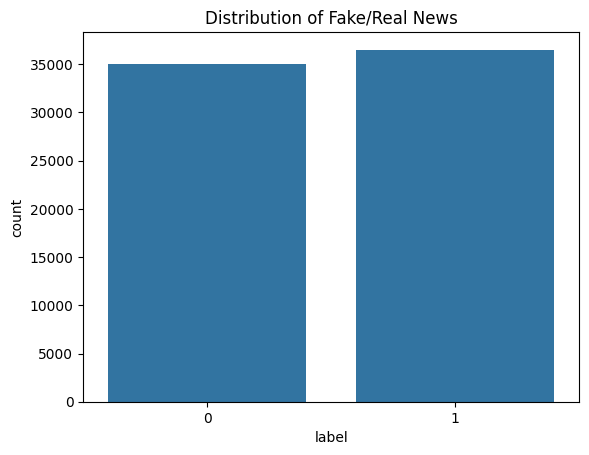

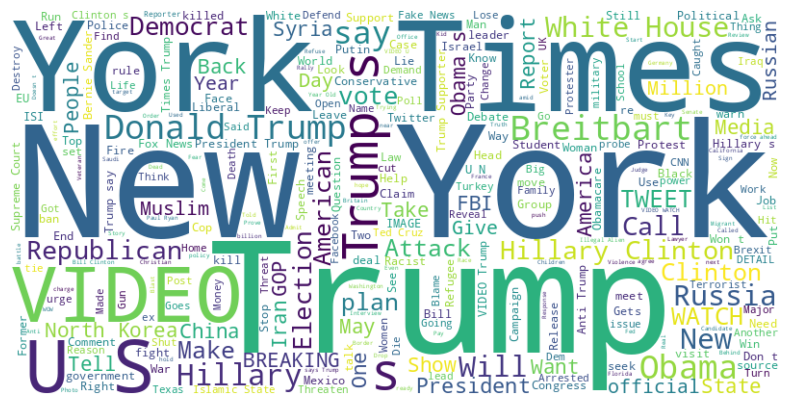

In [ ]:
# Distribution of labels
sns.barplot(x=y.value_counts().index, y=y.value_counts())
plt.title('Distribution of Fake/Real News')
plt.show()

# WordCloud for all titles
titles = ' '.join(title for title in df['title'])
wordcloud = WordCloud(background_color='white', max_words=300, width=800, height=400).generate(titles)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# Save vectorizer
pickle.dump(count_vectorizer, open("count_vect_title_text.pkl", "wb"))


In [12]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# Save vectorizer
pickle.dump(count_vectorizer, open("count_vect_title_text.pkl", "wb"))


In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)

# Predictions
pred_nb = nb_classifier.predict(count_test)

# Evaluation
print("Naive Bayes Classification Report:")
print(classification_report(y_test, pred_nb))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, pred_nb), annot=True, fmt='', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.show()

# Save model
pickle.dump(nb_classifier, open("nb_model_title_text.pkl", "wb"))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     11543
           1       0.93      0.94      0.94     12065

    accuracy                           0.94     23608
   macro avg       0.94      0.94      0.94     23608
weighted avg       0.94      0.94      0.94     23608



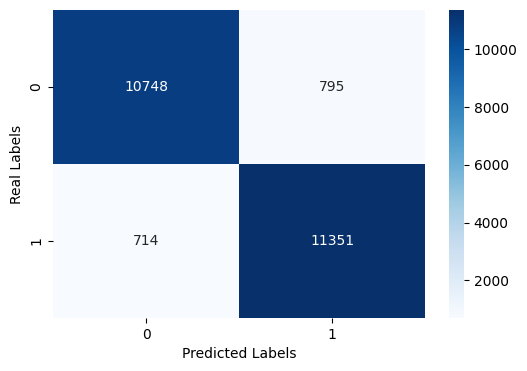

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=300)
rf_model.fit(count_train, y_train)

# Predictions
pred_rf = rf_model.predict(count_test)

# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, pred_rf))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, pred_rf), annot=True, fmt='', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.show()

# Save model
with open('rf_model.pkl','wb') as f:
    pickle.dump(rf_model, f)


In [19]:
# Example prediction using the trained Naive Bayes model
import pickle
from sklearn.feature_extraction.text import CountVectorizer

# Load the fitted vectorizer
with open("count_vect_title_text.pkl", "rb") as f:
    loaded_count_vectorizer = pickle.load(f)

# Use the loaded vectorizer to transform the example text
example_text = ["Imran Khan is in jail."]
example_vect = loaded_count_vectorizer.transform(example_text)

# Assuming nb_classifier is still available in the environment
print("Prediction (0=fake, 1=real):", nb_classifier.predict(example_vect))

Prediction (0=fake, 1=real): [1]


In [22]:
!pip install gradio  # Install Gradio if not already present

import gradio as gr
import pickle
from sklearn.feature_extraction.text import CountVectorizer

# Load saved components
with open("count_vect_title_text.pkl", "rb") as f:
    vectorizer = pickle.load(f)

with open("nb_model_title_text.pkl", "rb") as f:
    nb_model = pickle.load(f)

with open("rf_model.pkl", "rb") as f:
    rf_model = pickle.load(f)

def detect_fake_news(text, model_choice):
    """
    Predicts whether input text is fake (0) or real (1) news
    Returns prediction with confidence percentage
    """
    # Vectorize input text
    text_vector = vectorizer.transform([text])

    # Select model based on user choice
    if model_choice == "Naive Bayes":
        model = nb_model
        confidence = nb_model.predict_proba(text_vector)[0]
    else:
        model = rf_model
        confidence = rf_model.predict_proba(text_vector)[0]

    # Get prediction and confidence
    prediction = model.predict(text_vector)[0]
    confidence_percent = max(confidence) * 100

    # Format output
    result = "Fake News ❌" if prediction == 0 else "Real News ✅"
    return f"{result} (Confidence: {confidence_percent:.1f}%)"

# Create Gradio interface
demo = gr.Interface(
    fn=detect_fake_news,
    inputs=[
        gr.Textbox(label="Paste News Text", placeholder="Enter news content here..."),
        gr.Dropdown(["Naive Bayes", "Random Forest"], label="Model Selection", value="Naive Bayes")
    ],
    outputs=gr.Textbox(label="Detection Result"),
    title="🔍 Fake News Detector Dashboard",
    description="A machine learning-powered tool to identify potentially fake news articles",
    examples=[
        ["Imran Khan is in jail.", "Naive Bayes"],
        ["NASA announces discovery of new Earth-like exoplanet in habitable zone.", "Random Forest"]
    ],
    theme=gr.themes.Soft()
)

# Launch the interface with public sharing for Colab
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d52a77a97de235412e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
